# Random forest classifier using bleaching alert area (BAA) 

## Load dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sb
import matplotlib.pyplot as plt
import pingouin as pg
#from scipy.stats import shapiro, levene, bartlett, kruskal
import scikit_posthocs as sp
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score
from itertools import combinations, permutations

# Check scikit-learn version
from sklearn import __version__
print(__version__)

1.3.0


In [2]:
'''
    Load full dataset
'''
data = pd.read_csv('baa.csv')
data.head()

,|,ITEM_ID,COUNTRY,lat,lon,SEVERITY_CODE,MONTH,YEAR,dummy_date,baa,Confusion matrix,Cases
0,107,107,Comoros,-12.833333,45.216667,3,5,1986,1-5-1986,1.0,FN,4.0
1,108,108,Japan,26.500000,128.000000,3,6,1986,1-6-1986,NaN,TP,1.0
2,109,109,Barbados,13.039100,-59.523100,2,7,1986,1-7-1986,0.0,FN,4.0
3,111,111,United States,21.281062,-157.925008,3,8,1986,1-8-1986,0.0,FN,4.0
4,112,112,United States,18.383333,-154.633333,3,8,1986,1-8-1986,1.0,FN,4.0


In [3]:
'''
    Subset DF by SEVERITY_CODE [0,1,2,3]
'''
#data = data.dropna() # drop rows that contains NaN's 
data = data[(data.SEVERITY_CODE == 0)|(data.SEVERITY_CODE == 1)|(data.SEVERITY_CODE == 2)|(data.SEVERITY_CODE == 3)] 
#data = data[(data.YEAR >= 2015) & (data.YEAR <= 2016)] # subset a single event
#data = data[(data.YEAR >= 1997) & (data.YEAR <= 1998)] 
#list(data.columns)
data = data.dropna() # drop rows that contains NaN's
len(data)

35779

In [4]:
# len(data)
data.columns

Index(['|', 'ITEM_ID', 'COUNTRY', 'lat', 'lon', 'SEVERITY_CODE', 'MONTH',
       'YEAR', 'dummy_date', 'baa', 'Confusion matrix', 'Cases'],
      dtype='object')

In [5]:
'''
Editable variable's model 
'''
## 
X1=data[['Cases']] # Features (dependent variable)
y=data['SEVERITY_CODE'] #labels (indipendent variable)

In [6]:
'''
    Variance inflation factor VIF
'''
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Get variables for which to compute VIF and add intercept term
X1['Intercept'] = 1
# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X1.columns
vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
# View results using print
print(vif)

   variables       VIF
0      Cases  1.000000
1  Intercept  7.193645


C:\Users\PedroG_SFU\AppData\Local\Temp\ipykernel_40932\910329345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1['Intercept'] = 1


# Random forest classifier

In [7]:
'''
    Build the models
'''
model = RandomForestClassifier(n_estimators=200, random_state=10)
model.fit(X1,y)
# evaluate the model
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=10)
n_scores = cross_val_score(model, X1, y, cv=cv) #n_jobs=-1, error_score='raise'

In [8]:
'''
    Report performance
'''
print('Cross val score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print('\n')
# Features importance
print('=== features importances ===')
fi = pd.DataFrame({'feature': list(X1.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

Cross val score: 0.659 (0.005)


=== features importances ===


,feature,importance
0,Cases,1.0
1,Intercept,0.0


In [9]:
'''
    Confusion matrix
'''
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
y_pred=model.predict(X1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat_norm = confusion_matrix(y, y_pred,normalize='all')
print("=== Confusion matrix ===")
print(conf_mat)
print('\n')
print("=== Confusion matrix normalized ===")
print(conf_mat_norm)
print('\n')
print("=== Classification Report ===")
print(classification_report(y, y_pred))
print('\n')
print('=== Accuracy and Kappa ===')
print('accuracy', metrics.accuracy_score(y, y_pred))
print('\n')
print('kappa', metrics.cohen_kappa_score(y, y_pred))
print('\n')


=== Confusion matrix ===
[[14501   358     0     0]
 [ 7295   477     0     0]
 [    0     0  6572  1413]
 [    0     0  3122  2041]]


=== Confusion matrix normalized ===
[[0.40529361 0.01000587 0.         0.        ]
 [0.20389055 0.01333184 0.         0.        ]
 [0.         0.         0.18368317 0.03949244]
 [0.         0.         0.08725789 0.05704464]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.67      0.98      0.79     14859
           1       0.57      0.06      0.11      7772
           2       0.68      0.82      0.74      7985
           3       0.59      0.40      0.47      5163

    accuracy                           0.66     35779
   macro avg       0.63      0.56      0.53     35779
weighted avg       0.64      0.66      0.59     35779



=== Accuracy and Kappa ===
accuracy 0.6593532519075436


kappa 0.4896973686565592




In [10]:
'''
    Evaluation between classifications models through "log loss"
'''
model_probs = model.predict_proba(X1)
score = log_loss(y, model_probs)


'''
    Evaluation between classifications models through "ROC_AUC"
'''
roc_value = roc_auc_score(y, model_probs, multi_class='ovo') # ovo': Computes the average AUC of all possible pairwise combinations of classes

print('=== roc_auc_score ===') 
print(roc_value)
print(' ')
print('=== log_loss_score ===') 
print(score)


=== roc_auc_score ===
0.8546364191755381
 
=== log_loss_score ===
0.639836986793378


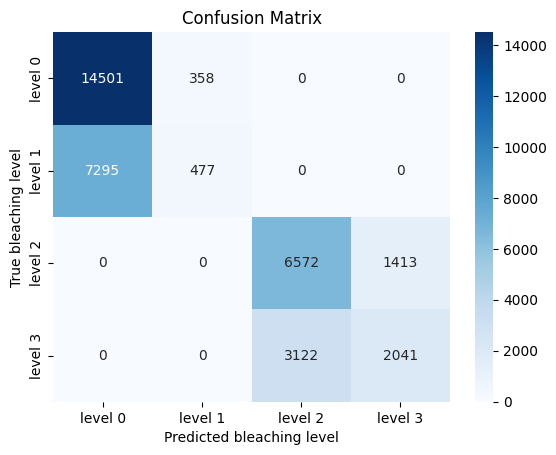

In [12]:
ax = plt.subplot()
#Heat map with annot=True to annotate cells
sb.heatmap(conf_mat, annot=True, ax = ax, fmt='d', cmap='Blues') # actual cases
#sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, ax = ax, fmt='.2%', cmap='Blues') #percentage
# labels, title and ticks
ax.set_xlabel('Predicted bleaching level');ax.set_ylabel('True bleaching level'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['level 0','level 1','level 2', 'level 3']); ax.yaxis.set_ticklabels(['level 0','level 1','level 2', 'level 3'])
plt.show()
#plt.savefig('DHW_monmean_CF_a_monmean.pdf', dpi=300)

In [13]:
comparisons = pd.DataFrame({'Real':y, 'Predictions':y_pred})
#comparisons.to_csv('comparisons.csv')
print(comparisons[['Real','Predictions']])

       Real  Predictions
0         3            2
2         2            2
3         3            2
4         3            2
5         2            2
...     ...          ...
35947     0            0
35948     0            0
35949     0            0
35950     3            2
35951     0            0

[35779 rows x 2 columns]
